# OVERALL OBJECTIVE:

What if Natural language processing can contribute to hermeneutics, the art of interpretation of the texts, or in general with the study of authors that played a major role in the history of thoughts? What insights can be reached due to this set of techniques? From the methodological point of view I suggest that conscious use of NLP accompanied by the traditional study of the works can offer insights based on testable and repeatable procedures.

It is also interesting to note how the need for such support in the case of very large productions is in accordance with the need for a large amount of data to apply sophisticated text mining techniques.

# CASE STUDY:

"John Dewey (October 20, 1859 – June 1, 1952) was an American philosopher, psychologist, and educational reformer whose ideas have been influential in education and social reform. He was one of the most prominent American scholars in the first half of the twentieth century." Wikipedia

What makes John Dewey so interesting for this research is the mass of written texts and his longevity as an author.

In [3]:
import pickle

In [4]:
corpus=pickle.load( open( "splitted_corpus2.pickle", "rb" ) )

In [5]:
print(corpus[0]['title: '])

The Early Works of John Dewey, 1882-1898. Volume 1 / Early essays / Early Essays
The Metaphysical Assumptions of Materialism 


In [6]:
print(corpus[0]['year: '])

1882


In [7]:
print(corpus[0]['text: '][:350])



Discussions regarding materialism have been, for the most
part, confined to the physiological and psychological aspects
of it. Its supporters and opponents have been content to
adduce arguments pro or con, as the facts of physical and
mental life bear upon the case in hand. It is the object of the
present paper to discuss its metaphysical phases.


There are over a thousand different texts in this corpus.

In [8]:
len(corpus)

1081

In [9]:
from collections import defaultdict

In [10]:
import nltk
from nltk.tokenize import word_tokenize

In [11]:
works_per_year=defaultdict(lambda: 0)
words_per_year=defaultdict(lambda: 0)
for work in corpus:
    works_per_year[int(work['year: '])]+=1
    words_per_year[int(work['year: '])]+=len(word_tokenize(work['text: ']))

The text are distributed over seventy years.

In [12]:
print(min(works_per_year.keys()),max(works_per_year.keys()))

1882 1952


<BarContainer object of 71 artists>

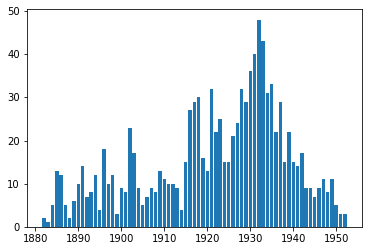

In [13]:
import matplotlib.pyplot as plt
plt.bar(works_per_year.keys(),works_per_year.values())

# GOAL:

The aim is to develop a procedure which can be used to have interesting insights on the overall production of the author 
and to point out how the use and the meaning associated with some words or concept changes during the life of the author (semantic shift).

The main idea is to use word2vec to obtain a word embedding for the overall production and for each period. Then with the use of unsupervised techniques try to visualize some interesting insights.

# PIPELINE:

## 1 Identify vocabulary and time windows
## 2 Word2Vec per period
## 3 Applications to research questions

## 1 Identify lexicon and time windows
### 1.0 Lexicon

I am interested in specific philosophical terms and to get rid of stop words. To do so, I compare the frequency of words with respect to a reference corpus

#### 1.0.1 Words frequency

In [14]:
#create a function that given a list of texts count each word
def word_counter(list_of_texts):
    words_count = defaultdict(lambda: 0)
    for doc in list_of_texts:
        for word in word_tokenize(doc):
            if word.isalpha():
                words_count[word.lower()] += 1
    return words_count

In [15]:
list_of_texts=[x['text: '] for x in corpus]

In [16]:
%%time
words_count=word_counter(list_of_texts)

Wall time: 2min 29s


In [17]:
words_count

defaultdict(<function __main__.word_counter.<locals>.<lambda>()>,
            {'discussions': 260,
             'regarding': 991,
             'materialism': 199,
             'have': 22610,
             'been': 9662,
             'for': 38459,
             'the': 368633,
             'most': 5532,
             'part': 4485,
             'confined': 353,
             'to': 145919,
             'physiological': 397,
             'and': 162793,
             'psychological': 1483,
             'aspects': 623,
             'of': 288520,
             'it': 66889,
             'its': 20841,
             'supporters': 32,
             'opponents': 96,
             'content': 1570,
             'adduce': 5,
             'arguments': 161,
             'pro': 26,
             'or': 34289,
             'con': 17,
             'as': 60444,
             'facts': 3347,
             'physical': 3642,
             'mental': 1918,
             'life': 8520,
             'bear': 500,
             'upon'

#### 1.0.1 Reference corpus

Inaugural address corpus + Gutemberg corpus

In [18]:
from nltk.corpus import inaugural

In [19]:
raw_list_of_reference_texts=[inaugural.words(speech) for speech in inaugural.fileids()[23:42]]

In [20]:
list_of_reference_texts=[' '.join(x) for x in raw_list_of_reference_texts]

In [21]:
len(list_of_reference_texts)

19

In [22]:
from nltk.corpus import gutenberg

In [23]:
#gutenberg.fileids() 
#which texts can be taken as a reference? those written between 1882-1952

#just the texts from chesterton, "an English writer, philosopher, lay theologian, and literary and art critic."

In [24]:
fileids=['chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt']

for fileid in fileids:
    num_chars = len(gutenberg.raw(fileid))
    num_words = len(gutenberg.words(fileid))
    num_sents = len(gutenberg.sents(fileid))
    num_vocab = len(set(w.lower() for w in gutenberg.words(fileid)))
    print(num_words, round(num_chars/num_words), round(num_words/num_sents), round(num_words/num_vocab), fileid)


96996 5 20 12 chesterton-ball.txt
86063 5 23 11 chesterton-brown.txt
69213 5 19 11 chesterton-thursday.txt


In [25]:
gut_list_of_texts=[' '.join(gutenberg.words(fileid)) for fileid in fileids]

In [26]:
list_of_reference_texts.extend(gut_list_of_texts)
len(list_of_reference_texts)

22

In [27]:
reference_words_count=word_counter(list_of_reference_texts)

In [28]:
reference_words_count

defaultdict(<function __main__.word_counter.<locals>.<lambda>()>,
            {'fellow': 86,
             'citizens': 64,
             'we': 1438,
             'stand': 81,
             'to': 5559,
             'day': 93,
             'upon': 379,
             'an': 938,
             'eminence': 3,
             'which': 1097,
             'overlooks': 2,
             'a': 6900,
             'hundred': 50,
             'years': 82,
             'of': 9065,
             'national': 76,
             'life': 181,
             'century': 39,
             'crowded': 9,
             'with': 2429,
             'perils': 8,
             'but': 1932,
             'crowned': 12,
             'the': 17015,
             'triumphs': 4,
             'liberty': 39,
             'and': 8543,
             'law': 110,
             'before': 281,
             'continuing': 7,
             'onward': 7,
             'march': 13,
             'let': 164,
             'us': 406,
             'pause': 36,
    

#### 1.0.2 Interesting words

In [29]:
tot=sum(words_count.values())
tot

5135254

In [30]:
reference_tot=sum(reference_words_count.values())
reference_tot

263059

In [31]:
dewey_dictionary=set(words_count.keys())
reference_dictionary=set(reference_words_count.keys())
print('Dewey dictionary: ',len(dewey_dictionary),'Reference dictionary: ',len(reference_dictionary))
print('Intersection: ',len(dewey_dictionary&reference_dictionary),'Union: ',len(dewey_dictionary|reference_dictionary))
print('Dif 1: ',len(dewey_dictionary-reference_dictionary),'Dif 2: ',len(reference_dictionary-dewey_dictionary))

Dewey dictionary:  39899 Reference dictionary:  15276
Intersection:  12358 Union:  42817
Dif 1:  27541 Dif 2:  2918


In [32]:
jaccard_similarity=len(dewey_dictionary&reference_dictionary)/len(dewey_dictionary|reference_dictionary)
jaccard_similarity

0.2886236775112689

How to select the relevant words?

In [33]:
scores={k : (words_count[k]-reference_words_count[k])/(words_count[k]+reference_words_count[k]) for k in dewey_dictionary&reference_dictionary}

In [34]:
scores={k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}

In [35]:
diff=dewey_dictionary-reference_dictionary
absentees_count={k:v for k,v in words_count.items() if k in diff}
absentees_count={k:v for k,v in sorted(absentees_count.items(), key=lambda item: item[1], reverse=True)}

An option is just to choose a list of words from the ones with the best scores or the most used but not present in the reference corpus.

In [36]:
interesting_words=[k for k,v in scores.items() if v>=0.995]

In [37]:
interesting_words.extend([k for k,v in absentees_count.items() if v>=300])

In [38]:
import pickle
pickle.dump( interesting_words, open( "interesting_words.pickle", "wb" ) )

In [2]:
len(interesting_words)

NameError: name 'interesting_words' is not defined

### 1.1 Time windows

<BarContainer object of 84 artists>

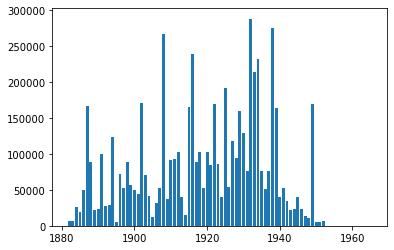

In [70]:
plt.bar(words_per_year.keys(),words_per_year.values())

In [71]:
sum(words_per_year.values())

5870449

In [72]:
sum(words_per_year.values())/5

1174089.8

In [73]:
len(words_per_year.keys())

84

In [74]:
for i in range(0,6):
    print(1882+i*14,1882+(i+1)*14)
    count_per_decade=0
    for j in range(1882+i*14,1882+(i+1)*14):
        count_per_decade+=words_per_year[j]
    print(count_per_decade)

1882 1896
693852
1896 1910
1050344
1910 1924
1432912
1924 1938
1804811
1938 1952
881944
1952 1966
6586


## 2 Word2Vec per period
### 2.1 Over all word embedding by word2vec

https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial

In [75]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [76]:
df = pd.DataFrame(corpus)

In [77]:
df = pd.DataFrame(df['text: '])
df = df.dropna().drop_duplicates()
df

INFO - 11:34:12: NumExpr defaulting to 4 threads.


,text:
0,\n\nDiscussions regarding materialism have bee...
1,\n\nThe problem of philosophy is to determine ...
2,\n\nThe doctrine of the Relativity of Knowledg...
3,"\n\nOn its subjective side, so far as individu..."
4,\n\nBacon's dictum regarding the proneness of ...
...,...
1076,Syllabi\nAncient Life and Thought in Relation ...
1077,Reports of Addresses\nMental Evolution and Its...
1078,\n\nInterview by Benjamin Stolberg\nIn the dim...
1079,\n\nInterview by Forrest Davis\nThe skyscraper...


In [78]:
sent = [row.split() for row in df['text: ']]

In [79]:
sent=[[re.sub("[^A-Za-z']+", '', str(w)).lower() for w in s] for s in sent]
# or sent=[[re.sub("[^A-Za-z']+", '', str(w)).lower() for w in s] for s in sent]

In [80]:
sent[0][:10]

['discussions',
 'regarding',
 'materialism',
 'have',
 'been',
 'for',
 'the',
 'most',
 'part',
 'confined']

In [81]:
from gensim.models.phrases import Phrases, Phraser

In [82]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 11:35:09: collecting all words and their counts
INFO - 11:35:09: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 11:35:26: collected 1100043 token types (unigram + bigrams) from a corpus of 5215953 words and 1081 sentences
INFO - 11:35:26: merged Phrases<1100043 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 11:35:26: Phrases lifecycle event {'msg': 'built Phrases<1100043 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 17.18s', 'datetime': '2022-08-29T11:35:26.564429', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [83]:
bigram = Phraser(phrases)

INFO - 11:35:26: exporting phrases from Phrases<1100043 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 11:35:34: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<723 phrases, min_count=30, threshold=10.0> from Phrases<1100043 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 7.68s', 'datetime': '2022-08-29T11:35:34.277477', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [84]:
sentences = bigram[sent]

In [85]:
sentences

In [86]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

61011

In [87]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['the', 'of', 'and', 'to', 'in', 'is', 'a', 'that', 'it', 'as']

#### Training the model

In [88]:
import multiprocessing

from gensim.models import Word2Vec

In [89]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [92]:
w2v_model = Word2Vec(min_count=20,
                     window=6,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.05, 
                     min_alpha=0.0001, 
                     negative=20,
                     workers=cores-1)

INFO - 11:37:26: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.05)', 'datetime': '2022-08-29T11:37:26.319107', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [93]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 11:37:29: collecting all words and their counts
INFO - 11:37:29: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 11:37:50: collected 61011 word types from a corpus of 5053257 raw words and 1081 sentences
INFO - 11:37:50: Creating a fresh vocabulary
INFO - 11:37:51: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 10448 unique words (17.124780777236893%% of original 61011, drops 50563)', 'datetime': '2022-08-29T11:37:51.118718', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'prepare_vocab'}
INFO - 11:37:51: Word2Vec lifecycle event {'msg': 'effective_min_count=20 leaves 4895384 word corpus (96.87581692361975%% of original 5053257, drops 157873)', 'datetime': '2022-08-29T11:37:51.118718', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'pre

Time to build vocab: 0.37 mins


In [94]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)


print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 11:38:01: Word2Vec lifecycle event {'msg': 'training model with 3 workers on 10448 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=6 shrink_windows=True', 'datetime': '2022-08-29T11:38:01.155895', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
INFO - 11:38:02: EPOCH 1 - PROGRESS: at 1.85% examples, 33226 words/s, in_qsize 1, out_qsize 0
INFO - 11:38:03: EPOCH 1 - PROGRESS: at 5.92% examples, 52277 words/s, in_qsize 5, out_qsize 1
INFO - 11:38:04: EPOCH 1 - PROGRESS: at 10.73% examples, 68348 words/s, in_qsize 5, out_qsize 0
INFO - 11:38:05: EPOCH 1 - PROGRESS: at 15.17% examples, 73443 words/s, in_qsize 5, out_qsize 0
INFO - 11:38:06: EPOCH 1 - PROGRESS: at 18.87% examples, 67268 words/s, in_qsize 5, out_qsize 0
INFO - 11:38:07: EPOCH 1 - PROGRESS: at 23.31% examples, 72207 words/s, in_qsize 1, out_qsize 0
INFO - 11:38:08: EPOCH 1 - PROGRESS

INFO - 11:39:18: EPOCH 4 - PROGRESS: at 87.33% examples, 71016 words/s, in_qsize 5, out_qsize 0
INFO - 11:39:19: EPOCH 4 - PROGRESS: at 98.89% examples, 72455 words/s, in_qsize 5, out_qsize 0
INFO - 11:39:19: worker thread finished; awaiting finish of 2 more threads
INFO - 11:39:19: worker thread finished; awaiting finish of 1 more threads
INFO - 11:39:19: worker thread finished; awaiting finish of 0 more threads
INFO - 11:39:19: EPOCH - 4 : training on 5053257 raw words (1444811 effective words) took 19.7s, 73321 effective words/s
INFO - 11:39:20: EPOCH 5 - PROGRESS: at 1.85% examples, 33759 words/s, in_qsize 5, out_qsize 0
INFO - 11:39:21: EPOCH 5 - PROGRESS: at 6.29% examples, 56208 words/s, in_qsize 5, out_qsize 0
INFO - 11:39:22: EPOCH 5 - PROGRESS: at 10.45% examples, 65777 words/s, in_qsize 5, out_qsize 0
INFO - 11:39:23: EPOCH 5 - PROGRESS: at 14.25% examples, 70767 words/s, in_qsize 5, out_qsize 0
INFO - 11:39:24: EPOCH 5 - PROGRESS: at 18.59% examples, 67959 words/s, in_qsize

INFO - 11:40:36: EPOCH 8 - PROGRESS: at 58.74% examples, 71334 words/s, in_qsize 3, out_qsize 0
INFO - 11:40:37: EPOCH 8 - PROGRESS: at 64.94% examples, 68819 words/s, in_qsize 1, out_qsize 0
INFO - 11:40:38: EPOCH 8 - PROGRESS: at 70.77% examples, 68795 words/s, in_qsize 1, out_qsize 0
INFO - 11:40:39: EPOCH 8 - PROGRESS: at 75.95% examples, 68584 words/s, in_qsize 1, out_qsize 1
INFO - 11:40:40: EPOCH 8 - PROGRESS: at 78.91% examples, 66300 words/s, in_qsize 1, out_qsize 0
INFO - 11:40:41: EPOCH 8 - PROGRESS: at 82.98% examples, 67101 words/s, in_qsize 5, out_qsize 0
INFO - 11:40:42: EPOCH 8 - PROGRESS: at 90.66% examples, 66781 words/s, in_qsize 2, out_qsize 0
INFO - 11:40:43: EPOCH 8 - PROGRESS: at 99.72% examples, 68192 words/s, in_qsize 3, out_qsize 0
INFO - 11:40:43: worker thread finished; awaiting finish of 2 more threads
INFO - 11:40:43: worker thread finished; awaiting finish of 1 more threads
INFO - 11:40:43: worker thread finished; awaiting finish of 0 more threads
INFO - 

INFO - 11:41:52: EPOCH 12 - PROGRESS: at 14.80% examples, 71973 words/s, in_qsize 5, out_qsize 1
INFO - 11:41:53: EPOCH 12 - PROGRESS: at 18.78% examples, 67714 words/s, in_qsize 2, out_qsize 0
INFO - 11:41:55: EPOCH 12 - PROGRESS: at 21.28% examples, 67554 words/s, in_qsize 1, out_qsize 0
INFO - 11:41:56: EPOCH 12 - PROGRESS: at 23.96% examples, 66096 words/s, in_qsize 0, out_qsize 1
INFO - 11:41:57: EPOCH 12 - PROGRESS: at 28.40% examples, 66724 words/s, in_qsize 6, out_qsize 0
INFO - 11:41:58: EPOCH 12 - PROGRESS: at 33.95% examples, 67536 words/s, in_qsize 5, out_qsize 0
INFO - 11:41:59: EPOCH 12 - PROGRESS: at 39.41% examples, 69508 words/s, in_qsize 0, out_qsize 1
INFO - 11:42:00: EPOCH 12 - PROGRESS: at 43.39% examples, 67909 words/s, in_qsize 5, out_qsize 0
INFO - 11:42:01: EPOCH 12 - PROGRESS: at 50.32% examples, 68903 words/s, in_qsize 0, out_qsize 1
INFO - 11:42:02: EPOCH 12 - PROGRESS: at 54.39% examples, 68457 words/s, in_qsize 6, out_qsize 0
INFO - 11:42:03: EPOCH 12 - PR

INFO - 11:43:10: EPOCH 16 - PROGRESS: at 2.13% examples, 57330 words/s, in_qsize 5, out_qsize 0
INFO - 11:43:11: EPOCH 16 - PROGRESS: at 6.94% examples, 64264 words/s, in_qsize 5, out_qsize 0
INFO - 11:43:12: EPOCH 16 - PROGRESS: at 11.66% examples, 74399 words/s, in_qsize 1, out_qsize 0
INFO - 11:43:13: EPOCH 16 - PROGRESS: at 16.56% examples, 78500 words/s, in_qsize 5, out_qsize 0
INFO - 11:43:14: EPOCH 16 - PROGRESS: at 19.43% examples, 71793 words/s, in_qsize 0, out_qsize 0
INFO - 11:43:15: EPOCH 16 - PROGRESS: at 22.20% examples, 69999 words/s, in_qsize 4, out_qsize 0
INFO - 11:43:16: EPOCH 16 - PROGRESS: at 24.24% examples, 69727 words/s, in_qsize 6, out_qsize 0
INFO - 11:43:17: EPOCH 16 - PROGRESS: at 31.73% examples, 71845 words/s, in_qsize 3, out_qsize 1
INFO - 11:43:18: EPOCH 16 - PROGRESS: at 38.30% examples, 75286 words/s, in_qsize 0, out_qsize 0
INFO - 11:43:19: EPOCH 16 - PROGRESS: at 42.65% examples, 73792 words/s, in_qsize 1, out_qsize 0
INFO - 11:43:20: EPOCH 16 - PROG

INFO - 11:44:27: worker thread finished; awaiting finish of 0 more threads
INFO - 11:44:27: EPOCH - 19 : training on 5053257 raw words (1444297 effective words) took 19.2s, 75385 effective words/s
INFO - 11:44:28: EPOCH 20 - PROGRESS: at 1.85% examples, 40760 words/s, in_qsize 5, out_qsize 0
INFO - 11:44:29: EPOCH 20 - PROGRESS: at 6.85% examples, 62532 words/s, in_qsize 5, out_qsize 0
INFO - 11:44:30: EPOCH 20 - PROGRESS: at 11.66% examples, 73712 words/s, in_qsize 6, out_qsize 0
INFO - 11:44:31: EPOCH 20 - PROGRESS: at 17.02% examples, 79466 words/s, in_qsize 3, out_qsize 1
INFO - 11:44:32: EPOCH 20 - PROGRESS: at 20.54% examples, 74484 words/s, in_qsize 0, out_qsize 0
INFO - 11:44:33: EPOCH 20 - PROGRESS: at 22.94% examples, 72315 words/s, in_qsize 0, out_qsize 1
INFO - 11:44:34: EPOCH 20 - PROGRESS: at 27.20% examples, 73230 words/s, in_qsize 5, out_qsize 0
INFO - 11:44:36: EPOCH 20 - PROGRESS: at 33.30% examples, 73742 words/s, in_qsize 6, out_qsize 0
INFO - 11:44:37: EPOCH 20 - P

INFO - 11:45:46: worker thread finished; awaiting finish of 2 more threads
INFO - 11:45:46: worker thread finished; awaiting finish of 1 more threads
INFO - 11:45:46: worker thread finished; awaiting finish of 0 more threads
INFO - 11:45:46: EPOCH - 23 : training on 5053257 raw words (1444001 effective words) took 19.3s, 74783 effective words/s
INFO - 11:45:47: EPOCH 24 - PROGRESS: at 1.85% examples, 40748 words/s, in_qsize 5, out_qsize 0
INFO - 11:45:48: EPOCH 24 - PROGRESS: at 6.38% examples, 54798 words/s, in_qsize 6, out_qsize 1
INFO - 11:45:49: EPOCH 24 - PROGRESS: at 11.01% examples, 69493 words/s, in_qsize 5, out_qsize 0
INFO - 11:45:50: EPOCH 24 - PROGRESS: at 17.48% examples, 79913 words/s, in_qsize 2, out_qsize 0
INFO - 11:45:51: EPOCH 24 - PROGRESS: at 20.63% examples, 73932 words/s, in_qsize 0, out_qsize 0
INFO - 11:45:52: EPOCH 24 - PROGRESS: at 22.76% examples, 70283 words/s, in_qsize 3, out_qsize 1
INFO - 11:45:53: EPOCH 24 - PROGRESS: at 27.75% examples, 74327 words/s, 

INFO - 11:47:02: EPOCH 27 - PROGRESS: at 97.69% examples, 74342 words/s, in_qsize 6, out_qsize 0
INFO - 11:47:02: worker thread finished; awaiting finish of 2 more threads
INFO - 11:47:02: worker thread finished; awaiting finish of 1 more threads
INFO - 11:47:02: worker thread finished; awaiting finish of 0 more threads
INFO - 11:47:02: EPOCH - 27 : training on 5053257 raw words (1444180 effective words) took 19.1s, 75439 effective words/s
INFO - 11:47:03: EPOCH 28 - PROGRESS: at 1.85% examples, 33949 words/s, in_qsize 3, out_qsize 0
INFO - 11:47:04: EPOCH 28 - PROGRESS: at 6.20% examples, 56937 words/s, in_qsize 5, out_qsize 0
INFO - 11:47:05: EPOCH 28 - PROGRESS: at 10.45% examples, 65971 words/s, in_qsize 5, out_qsize 0
INFO - 11:47:06: EPOCH 28 - PROGRESS: at 14.80% examples, 73404 words/s, in_qsize 6, out_qsize 0
INFO - 11:47:07: EPOCH 28 - PROGRESS: at 18.87% examples, 69725 words/s, in_qsize 2, out_qsize 0
INFO - 11:47:08: EPOCH 28 - PROGRESS: at 21.46% examples, 68440 words/s, 

INFO - 11:48:19: EPOCH 31 - PROGRESS: at 97.50% examples, 73739 words/s, in_qsize 5, out_qsize 0
INFO - 11:48:20: worker thread finished; awaiting finish of 2 more threads
INFO - 11:48:20: worker thread finished; awaiting finish of 1 more threads
INFO - 11:48:20: worker thread finished; awaiting finish of 0 more threads
INFO - 11:48:20: EPOCH - 31 : training on 5053257 raw words (1443954 effective words) took 19.4s, 74585 effective words/s
INFO - 11:48:21: EPOCH 32 - PROGRESS: at 1.85% examples, 33153 words/s, in_qsize 3, out_qsize 0
INFO - 11:48:22: EPOCH 32 - PROGRESS: at 6.20% examples, 56338 words/s, in_qsize 5, out_qsize 0
INFO - 11:48:23: EPOCH 32 - PROGRESS: at 10.73% examples, 70066 words/s, in_qsize 5, out_qsize 0
INFO - 11:48:24: EPOCH 32 - PROGRESS: at 15.08% examples, 74224 words/s, in_qsize 6, out_qsize 0
INFO - 11:48:25: EPOCH 32 - PROGRESS: at 18.87% examples, 68985 words/s, in_qsize 2, out_qsize 1
INFO - 11:48:26: EPOCH 32 - PROGRESS: at 22.29% examples, 69654 words/s, 

INFO - 11:49:35: EPOCH 35 - PROGRESS: at 80.67% examples, 73399 words/s, in_qsize 2, out_qsize 0
INFO - 11:49:36: EPOCH 35 - PROGRESS: at 86.22% examples, 73173 words/s, in_qsize 4, out_qsize 0
INFO - 11:49:37: EPOCH 35 - PROGRESS: at 97.41% examples, 74090 words/s, in_qsize 5, out_qsize 0
INFO - 11:49:38: worker thread finished; awaiting finish of 2 more threads
INFO - 11:49:38: worker thread finished; awaiting finish of 1 more threads
INFO - 11:49:38: worker thread finished; awaiting finish of 0 more threads
INFO - 11:49:38: EPOCH - 35 : training on 5053257 raw words (1444689 effective words) took 19.2s, 75173 effective words/s
INFO - 11:49:39: EPOCH 36 - PROGRESS: at 1.85% examples, 33355 words/s, in_qsize 3, out_qsize 1
INFO - 11:49:40: EPOCH 36 - PROGRESS: at 6.29% examples, 58464 words/s, in_qsize 5, out_qsize 0
INFO - 11:49:41: EPOCH 36 - PROGRESS: at 10.73% examples, 69889 words/s, in_qsize 5, out_qsize 0
INFO - 11:49:42: EPOCH 36 - PROGRESS: at 14.80% examples, 72650 words/s, 

INFO - 11:50:54: EPOCH 39 - PROGRESS: at 48.47% examples, 72347 words/s, in_qsize 4, out_qsize 0
INFO - 11:50:55: EPOCH 39 - PROGRESS: at 56.89% examples, 73832 words/s, in_qsize 6, out_qsize 0
INFO - 11:50:56: EPOCH 39 - PROGRESS: at 64.38% examples, 71880 words/s, in_qsize 0, out_qsize 0
INFO - 11:50:57: EPOCH 39 - PROGRESS: at 67.25% examples, 71292 words/s, in_qsize 5, out_qsize 0
INFO - 11:50:59: EPOCH 39 - PROGRESS: at 75.86% examples, 71704 words/s, in_qsize 2, out_qsize 0
INFO - 11:51:00: EPOCH 39 - PROGRESS: at 80.67% examples, 71534 words/s, in_qsize 5, out_qsize 0
INFO - 11:51:01: EPOCH 39 - PROGRESS: at 86.40% examples, 71489 words/s, in_qsize 3, out_qsize 1
INFO - 11:51:02: EPOCH 39 - PROGRESS: at 96.67% examples, 71244 words/s, in_qsize 6, out_qsize 0
INFO - 11:51:02: worker thread finished; awaiting finish of 2 more threads
INFO - 11:51:02: worker thread finished; awaiting finish of 1 more threads
INFO - 11:51:02: worker thread finished; awaiting finish of 0 more threads

INFO - 11:52:12: EPOCH 43 - PROGRESS: at 35.25% examples, 67910 words/s, in_qsize 4, out_qsize 0
INFO - 11:52:13: EPOCH 43 - PROGRESS: at 41.54% examples, 68699 words/s, in_qsize 0, out_qsize 0
INFO - 11:52:14: EPOCH 43 - PROGRESS: at 46.16% examples, 68679 words/s, in_qsize 5, out_qsize 1
INFO - 11:52:15: EPOCH 43 - PROGRESS: at 52.08% examples, 70430 words/s, in_qsize 2, out_qsize 0
INFO - 11:52:16: EPOCH 43 - PROGRESS: at 58.65% examples, 69737 words/s, in_qsize 4, out_qsize 0
INFO - 11:52:17: EPOCH 43 - PROGRESS: at 65.22% examples, 70073 words/s, in_qsize 3, out_qsize 1
INFO - 11:52:18: EPOCH 43 - PROGRESS: at 71.14% examples, 69375 words/s, in_qsize 5, out_qsize 0
INFO - 11:52:19: EPOCH 43 - PROGRESS: at 77.61% examples, 68671 words/s, in_qsize 0, out_qsize 2
INFO - 11:52:20: EPOCH 43 - PROGRESS: at 81.04% examples, 68119 words/s, in_qsize 6, out_qsize 4
INFO - 11:52:21: EPOCH 43 - PROGRESS: at 90.66% examples, 69394 words/s, in_qsize 2, out_qsize 0
INFO - 11:52:22: worker thread

INFO - 11:53:28: EPOCH 47 - PROGRESS: at 24.24% examples, 67817 words/s, in_qsize 3, out_qsize 0
INFO - 11:53:29: EPOCH 47 - PROGRESS: at 31.27% examples, 69650 words/s, in_qsize 4, out_qsize 1
INFO - 11:53:30: EPOCH 47 - PROGRESS: at 36.82% examples, 71262 words/s, in_qsize 3, out_qsize 0
INFO - 11:53:31: EPOCH 47 - PROGRESS: at 42.09% examples, 70784 words/s, in_qsize 5, out_qsize 0
INFO - 11:53:32: EPOCH 47 - PROGRESS: at 47.92% examples, 72959 words/s, in_qsize 3, out_qsize 0
INFO - 11:53:33: EPOCH 47 - PROGRESS: at 55.32% examples, 74288 words/s, in_qsize 6, out_qsize 0
INFO - 11:53:34: EPOCH 47 - PROGRESS: at 63.55% examples, 72803 words/s, in_qsize 4, out_qsize 0
INFO - 11:53:35: EPOCH 47 - PROGRESS: at 70.40% examples, 73378 words/s, in_qsize 1, out_qsize 0
INFO - 11:53:37: EPOCH 47 - PROGRESS: at 76.41% examples, 73619 words/s, in_qsize 1, out_qsize 0
INFO - 11:53:38: EPOCH 47 - PROGRESS: at 80.48% examples, 73057 words/s, in_qsize 2, out_qsize 0
INFO - 11:53:39: EPOCH 47 - PR

INFO - 11:54:48: EPOCH 50 - PROGRESS: at 91.40% examples, 73053 words/s, in_qsize 6, out_qsize 0
INFO - 11:54:49: worker thread finished; awaiting finish of 2 more threads
INFO - 11:54:49: worker thread finished; awaiting finish of 1 more threads
INFO - 11:54:49: worker thread finished; awaiting finish of 0 more threads
INFO - 11:54:49: EPOCH - 50 : training on 5053257 raw words (1444083 effective words) took 19.4s, 74599 effective words/s
INFO - 11:54:49: Word2Vec lifecycle event {'msg': 'training on 252662850 raw words (72208785 effective words) took 1008.3s, 71616 effective words/s', 'datetime': '2022-08-29T11:54:49.436645', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}


Time to train the model: 16.8 mins


In [95]:
w2v_model.save("word2vec.model")

INFO - 11:54:49: Word2Vec lifecycle event {'fname_or_handle': 'word2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-08-29T11:54:49.456151', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'saving'}
INFO - 11:54:49: not storing attribute cum_table
INFO - 11:54:49: saved word2vec.model


### Exploration & validation of the embedding

In [107]:
interesting_words[:5]

['educational', 'psychology', 'function', 'external', 'specific']

In [612]:
w2v_model.wv.most_similar(positive=["dewey"])

[("dewey's", 0.35872310400009155),
 ('keats', 0.34304773807525635),
 ('december_', 0.3287704586982727),
 ('letter', 0.32806074619293213),
 ('louis', 0.3212338387966156),
 ('mezes', 0.3189712166786194),
 ('edward', 0.30171704292297363),
 ('barnes', 0.30048269033432007),
 ('unpublished', 0.290042906999588),
 ('july_', 0.28706902265548706)]

In [109]:
w2v_model.wv.most_similar(positive=["function"])

[('functions', 0.44728827476501465),
 ('process', 0.36713576316833496),
 ('meaning', 0.35355210304260254),
 ('reference', 0.34959155321121216),
 ('its', 0.34335288405418396),
 ('purpose', 0.34275057911872864),
 ('operation', 0.34015777707099915),
 ('directive', 0.3380606472492218),
 ('relation', 0.3291893005371094),
 ('factor', 0.32507243752479553)]

In [96]:
w2v_model.wv.most_similar(positive=["kant"])

[('hegel', 0.4374355673789978),
 ("kant's", 0.43361929059028625),
 ('fichte', 0.43257033824920654),
 ('kantian', 0.38889387249946594),
 ('successors', 0.3428676128387451),
 ('thought', 0.33499830961227417),
 ('thinginitself', 0.33497729897499084),
 ('caird', 0.3333476781845093),
 ('hegelian', 0.3284324109554291),
 ('reason', 0.3278566300868988)]

In [97]:
w2v_model.wv.most_similar(positive=["i"])

[('my', 0.661733090877533),
 ('you', 0.5315725207328796),
 ('me', 0.5234560370445251),
 ('do_not', 0.5059517025947571),
 ('i_am', 0.49819090962409973),
 ('i_shall', 0.4561975300312042),
 ('myself', 0.43922415375709534),
 ('i_wish', 0.4387105703353882),
 ('mr', 0.43870994448661804),
 ('here', 0.4367556571960449)]

In [98]:
w2v_model.wv.most_similar(positive=["dewey"])

[("dewey's", 0.35872310400009155),
 ('keats', 0.34304773807525635),
 ('december_', 0.3287704586982727),
 ('letter', 0.32806074619293213),
 ('louis', 0.3212338387966156),
 ('mezes', 0.3189712166786194),
 ('edward', 0.30171704292297363),
 ('barnes', 0.30048269033432007),
 ('unpublished', 0.290042906999588),
 ('july_', 0.28706902265548706)]

In [99]:
w2v_model.wv.most_similar(positive=["darwin"])

[("darwin's", 0.3438131511211395),
 ('london_', 0.2664700448513031),
 ('bosanquet', 0.2613988220691681),
 ('helmholtz', 0.2569342255592346),
 ('fiske', 0.25606417655944824),
 ('herbert', 0.25168824195861816),
 ('th_century', 0.2458799183368683),
 ('spencer', 0.2442215532064438),
 ('der_psychologie', 0.24367040395736694),
 ('pope', 0.24308082461357117)]

In [100]:
w2v_model.wv.similarity("kant", 'hegel')

0.43743557

In [101]:
w2v_model.wv.most_similar(positive=["pragmatism"])

[('pragmatic', 0.42806515097618103),
 ('instrumentalism', 0.3947717547416687),
 ('pragmatist', 0.36399126052856445),
 ('philosophy', 0.3410487174987793),
 ('empiricism', 0.33884677290916443),
 ('voluntarism', 0.33863958716392517),
 ('peirce', 0.32479187846183777),
 ('james', 0.3238891363143921),
 ('philosophical', 0.3041110038757324),
 ('theory', 0.2918098270893097)]

In [102]:
w2v_model.wv.similarity("idealism", 'rationalism')

0.39820218

In [103]:
w2v_model.wv.doesnt_match(['hegel', 'fichte', 'locke'])

'locke'

In [104]:
w2v_model.wv.most_similar(positive=["idealism", "kant"], negative=["hegel"], topn=3)

[('rationalism', 0.32210853695869446),
 ('monism', 0.2707808315753937),
 ('successors', 0.2498893439769745)]

In [610]:
w2v_model.wv.most_similar(positive=["idealism", "james"], negative=["hegel"], topn=3)

[('pragmatism', 0.30753442645072937),
 ('william_james', 0.29011261463165283),
 ("russell's", 0.2491713911294937)]

In [611]:
w2v_model.wv.most_similar(positive=["materialism","body"], negative=["mind"], topn=3)

[('materialistic', 0.2541663944721222),
 ('dogma', 0.2368171364068985),
 ('sprung', 0.22213208675384521)]

#### t-SNE visualizations

In [110]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [111]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=16).fit_transform(arrays)  #why not 50/17?
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
   # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

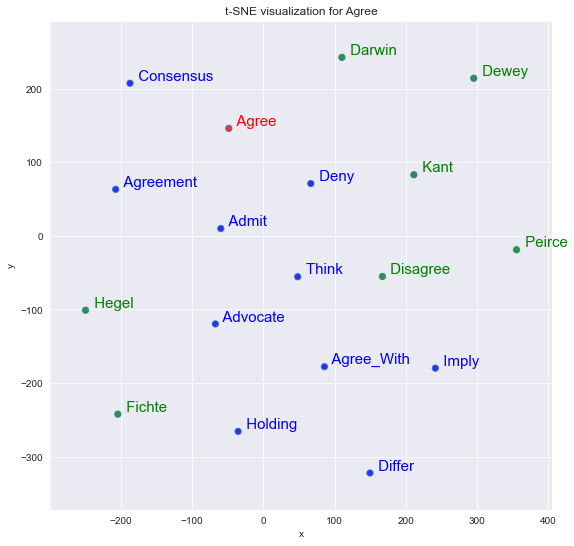

In [134]:
tsnescatterplot(w2v_model, 'agree', ['hegel', 'fichte', 'kant','darwin','disagree', 'dewey', 'peirce'])

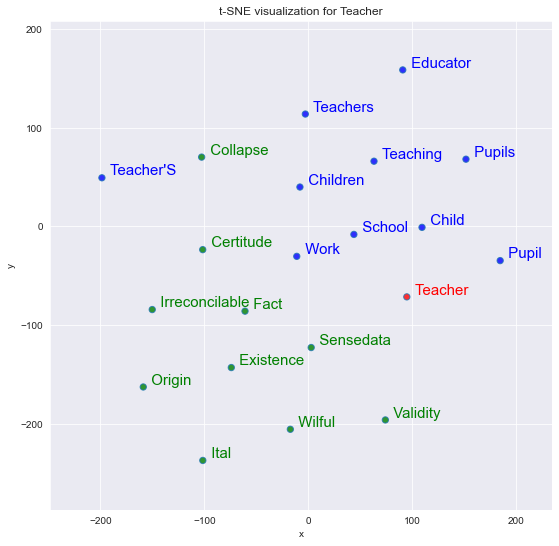

In [113]:
tsnescatterplot(w2v_model, 'teacher', [i[0] for i in w2v_model.wv.most_similar(negative=["teacher"])])


### Word embedding per period

In [318]:
periods=((1881,1898),(1898,1924),(1924,1952)) # early middle and later works

In [319]:
%time
text_per_period=list()
df = pd.DataFrame(corpus)
df = df.astype({"year: ": int}, errors='raise') 
for y1,y2 in periods:
    df_per_period=df[(df['year: ']>y1)&(df['year: ']<=y2)]
    df_per_period = pd.DataFrame(df['text: '])
    df_per_period = df.dropna().drop_duplicates()
    sent = [row.split() for row in df_per_period['text: ']]
    sent=[[re.sub("[^A-Za-z']+", '', str(w)).lower() for w in s] for s in sent]
    phrases = Phrases(sent, min_count=30, progress_per=10000)
    bigram = Phraser(phrases)
    sentences = bigram[sent]
    text_per_period.append(sentences)

Wall time: 0 ns


INFO - 15:14:29: collecting all words and their counts
INFO - 15:14:29: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:14:49: collected 1100043 token types (unigram + bigrams) from a corpus of 5215953 words and 1081 sentences
INFO - 15:14:49: merged Phrases<1100043 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 15:14:49: Phrases lifecycle event {'msg': 'built Phrases<1100043 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 19.50s', 'datetime': '2022-08-30T15:14:49.280449', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}
INFO - 15:14:51: exporting phrases from Phrases<1100043 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 15:14:59: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<723 phrases, min_count=30, threshold=10.0> from Phrases<1100043 vocab, min_count=30, threshold=10.0, ma

In [321]:
from gensim.models import KeyedVectors

In [322]:
embedding_per_period=list()
for texts in text_per_period:
    model = Word2Vec.load("word2vec.model")
    model.train(texts, total_examples=w2v_model.corpus_count, epochs=20, report_delay=1)
    embedding_per_period.append(model.wv)

INFO - 15:17:23: loading Word2Vec object from word2vec.model
INFO - 15:17:24: loading wv recursively from word2vec.model.wv.* with mmap=None
INFO - 15:17:24: setting ignored attribute cum_table to None
INFO - 15:17:24: Word2Vec lifecycle event {'fname': 'word2vec.model', 'datetime': '2022-08-30T15:17:24.385439', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'loaded'}
WARNING - 15:17:24: Effective 'alpha' higher than previous training cycles
INFO - 15:17:24: Word2Vec lifecycle event {'msg': 'training model with 3 workers on 10448 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=6 shrink_windows=True', 'datetime': '2022-08-30T15:17:24.401037', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
INFO - 15:17:25: EPOCH 1 - PROGRESS: at 1.76% examples, 31310

INFO - 15:18:34: EPOCH 4 - PROGRESS: at 36.45% examples, 68810 words/s, in_qsize 4, out_qsize 1
INFO - 15:18:35: EPOCH 4 - PROGRESS: at 42.18% examples, 68974 words/s, in_qsize 4, out_qsize 0
INFO - 15:18:36: EPOCH 4 - PROGRESS: at 46.99% examples, 70168 words/s, in_qsize 4, out_qsize 1
INFO - 15:18:37: EPOCH 4 - PROGRESS: at 52.45% examples, 70439 words/s, in_qsize 6, out_qsize 0
INFO - 15:18:38: EPOCH 4 - PROGRESS: at 59.85% examples, 70261 words/s, in_qsize 1, out_qsize 0
INFO - 15:18:39: EPOCH 4 - PROGRESS: at 66.14% examples, 69891 words/s, in_qsize 5, out_qsize 0
INFO - 15:18:40: EPOCH 4 - PROGRESS: at 71.97% examples, 69836 words/s, in_qsize 5, out_qsize 0
INFO - 15:18:42: EPOCH 4 - PROGRESS: at 78.63% examples, 68530 words/s, in_qsize 1, out_qsize 0
INFO - 15:18:43: EPOCH 4 - PROGRESS: at 82.52% examples, 69582 words/s, in_qsize 6, out_qsize 0
INFO - 15:18:44: EPOCH 4 - PROGRESS: at 90.47% examples, 69142 words/s, in_qsize 6, out_qsize 0
INFO - 15:18:45: worker thread finished;

INFO - 15:19:53: EPOCH 8 - PROGRESS: at 29.32% examples, 63013 words/s, in_qsize 3, out_qsize 1
INFO - 15:19:54: EPOCH 8 - PROGRESS: at 35.25% examples, 67256 words/s, in_qsize 4, out_qsize 1
INFO - 15:19:55: EPOCH 8 - PROGRESS: at 40.06% examples, 65949 words/s, in_qsize 4, out_qsize 1
INFO - 15:19:56: EPOCH 8 - PROGRESS: at 42.46% examples, 61903 words/s, in_qsize 1, out_qsize 0
INFO - 15:19:57: EPOCH 8 - PROGRESS: at 46.53% examples, 61940 words/s, in_qsize 0, out_qsize 0
INFO - 15:19:58: EPOCH 8 - PROGRESS: at 50.97% examples, 60119 words/s, in_qsize 0, out_qsize 0
INFO - 15:19:59: EPOCH 8 - PROGRESS: at 51.80% examples, 57742 words/s, in_qsize 0, out_qsize 0
INFO - 15:20:00: EPOCH 8 - PROGRESS: at 54.76% examples, 56187 words/s, in_qsize 0, out_qsize 0
INFO - 15:20:01: EPOCH 8 - PROGRESS: at 61.98% examples, 55800 words/s, in_qsize 0, out_qsize 1
INFO - 15:20:03: EPOCH 8 - PROGRESS: at 64.20% examples, 52016 words/s, in_qsize 0, out_qsize 0
INFO - 15:20:05: EPOCH 8 - PROGRESS: at 

INFO - 15:21:18: EPOCH 11 - PROGRESS: at 38.30% examples, 69935 words/s, in_qsize 2, out_qsize 1
INFO - 15:21:19: EPOCH 11 - PROGRESS: at 42.55% examples, 69397 words/s, in_qsize 0, out_qsize 1
INFO - 15:21:20: EPOCH 11 - PROGRESS: at 47.55% examples, 69460 words/s, in_qsize 4, out_qsize 0
INFO - 15:21:21: EPOCH 11 - PROGRESS: at 52.91% examples, 70185 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:22: EPOCH 11 - PROGRESS: at 63.55% examples, 69723 words/s, in_qsize 1, out_qsize 0
INFO - 15:21:23: EPOCH 11 - PROGRESS: at 66.98% examples, 69685 words/s, in_qsize 3, out_qsize 0
INFO - 15:21:24: EPOCH 11 - PROGRESS: at 73.91% examples, 69754 words/s, in_qsize 6, out_qsize 0
INFO - 15:21:25: EPOCH 11 - PROGRESS: at 79.00% examples, 68606 words/s, in_qsize 0, out_qsize 0
INFO - 15:21:26: EPOCH 11 - PROGRESS: at 85.20% examples, 69692 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:27: EPOCH 11 - PROGRESS: at 90.75% examples, 68894 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:28: worker thread

INFO - 15:22:37: EPOCH 15 - PROGRESS: at 24.14% examples, 64899 words/s, in_qsize 0, out_qsize 0
INFO - 15:22:38: EPOCH 15 - PROGRESS: at 29.32% examples, 65511 words/s, in_qsize 6, out_qsize 0
INFO - 15:22:39: EPOCH 15 - PROGRESS: at 34.23% examples, 67226 words/s, in_qsize 5, out_qsize 0
INFO - 15:22:40: EPOCH 15 - PROGRESS: at 40.52% examples, 68864 words/s, in_qsize 1, out_qsize 0
INFO - 15:22:41: EPOCH 15 - PROGRESS: at 43.02% examples, 65898 words/s, in_qsize 2, out_qsize 1
INFO - 15:22:42: EPOCH 15 - PROGRESS: at 47.36% examples, 65953 words/s, in_qsize 3, out_qsize 1
INFO - 15:22:43: EPOCH 15 - PROGRESS: at 52.27% examples, 65919 words/s, in_qsize 5, out_qsize 0
INFO - 15:22:44: EPOCH 15 - PROGRESS: at 58.74% examples, 65650 words/s, in_qsize 3, out_qsize 0
INFO - 15:22:45: EPOCH 15 - PROGRESS: at 65.12% examples, 65219 words/s, in_qsize 1, out_qsize 0
INFO - 15:22:46: EPOCH 15 - PROGRESS: at 70.77% examples, 64739 words/s, in_qsize 3, out_qsize 0
INFO - 15:22:47: EPOCH 15 - PR

INFO - 15:23:54: EPOCH - 18 : training on 5053257 raw words (1443929 effective words) took 20.4s, 70628 effective words/s
INFO - 15:23:55: EPOCH 19 - PROGRESS: at 1.85% examples, 31041 words/s, in_qsize 1, out_qsize 0
INFO - 15:23:56: EPOCH 19 - PROGRESS: at 6.29% examples, 53399 words/s, in_qsize 5, out_qsize 0
INFO - 15:23:57: EPOCH 19 - PROGRESS: at 10.55% examples, 66489 words/s, in_qsize 5, out_qsize 0
INFO - 15:23:58: EPOCH 19 - PROGRESS: at 14.25% examples, 69654 words/s, in_qsize 5, out_qsize 0
INFO - 15:23:59: EPOCH 19 - PROGRESS: at 18.87% examples, 66273 words/s, in_qsize 1, out_qsize 0
INFO - 15:24:00: EPOCH 19 - PROGRESS: at 22.66% examples, 67922 words/s, in_qsize 0, out_qsize 1
INFO - 15:24:01: EPOCH 19 - PROGRESS: at 24.51% examples, 66088 words/s, in_qsize 1, out_qsize 0
INFO - 15:24:02: EPOCH 19 - PROGRESS: at 30.62% examples, 68488 words/s, in_qsize 3, out_qsize 0
INFO - 15:24:03: EPOCH 19 - PROGRESS: at 34.97% examples, 69409 words/s, in_qsize 6, out_qsize 0
INFO - 

INFO - 15:24:59: EPOCH 2 - PROGRESS: at 17.95% examples, 82659 words/s, in_qsize 0, out_qsize 0
INFO - 15:25:00: EPOCH 2 - PROGRESS: at 20.63% examples, 75199 words/s, in_qsize 4, out_qsize 0
INFO - 15:25:01: EPOCH 2 - PROGRESS: at 23.03% examples, 73107 words/s, in_qsize 1, out_qsize 0
INFO - 15:25:02: EPOCH 2 - PROGRESS: at 27.10% examples, 73175 words/s, in_qsize 5, out_qsize 0
INFO - 15:25:03: EPOCH 2 - PROGRESS: at 32.93% examples, 72325 words/s, in_qsize 5, out_qsize 0
INFO - 15:25:04: EPOCH 2 - PROGRESS: at 38.21% examples, 74145 words/s, in_qsize 4, out_qsize 1
INFO - 15:25:05: EPOCH 2 - PROGRESS: at 42.65% examples, 73537 words/s, in_qsize 5, out_qsize 0
INFO - 15:25:07: EPOCH 2 - PROGRESS: at 48.47% examples, 73902 words/s, in_qsize 2, out_qsize 0
INFO - 15:25:08: EPOCH 2 - PROGRESS: at 56.61% examples, 75060 words/s, in_qsize 6, out_qsize 0
INFO - 15:25:09: EPOCH 2 - PROGRESS: at 63.55% examples, 72858 words/s, in_qsize 2, out_qsize 0
INFO - 15:25:10: EPOCH 2 - PROGRESS: at 

INFO - 15:26:15: EPOCH 6 - PROGRESS: at 1.76% examples, 30182 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:16: EPOCH 6 - PROGRESS: at 5.83% examples, 51212 words/s, in_qsize 5, out_qsize 2
INFO - 15:26:17: EPOCH 6 - PROGRESS: at 11.01% examples, 69210 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:18: EPOCH 6 - PROGRESS: at 15.08% examples, 73211 words/s, in_qsize 6, out_qsize 0
INFO - 15:26:19: EPOCH 6 - PROGRESS: at 18.87% examples, 67174 words/s, in_qsize 0, out_qsize 0
INFO - 15:26:20: EPOCH 6 - PROGRESS: at 20.63% examples, 61340 words/s, in_qsize 0, out_qsize 0
INFO - 15:26:21: EPOCH 6 - PROGRESS: at 23.87% examples, 63004 words/s, in_qsize 0, out_qsize 0
INFO - 15:26:22: EPOCH 6 - PROGRESS: at 27.57% examples, 64032 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:23: EPOCH 6 - PROGRESS: at 33.77% examples, 65263 words/s, in_qsize 1, out_qsize 0
INFO - 15:26:25: EPOCH 6 - PROGRESS: at 38.02% examples, 65408 words/s, in_qsize 5, out_qsize 1
INFO - 15:26:26: EPOCH 6 - PROGRESS: at 42

INFO - 15:27:34: worker thread finished; awaiting finish of 2 more threads
INFO - 15:27:34: worker thread finished; awaiting finish of 1 more threads
INFO - 15:27:34: worker thread finished; awaiting finish of 0 more threads
INFO - 15:27:34: EPOCH - 9 : training on 5053257 raw words (1443918 effective words) took 20.2s, 71549 effective words/s
INFO - 15:27:36: EPOCH 10 - PROGRESS: at 1.85% examples, 23160 words/s, in_qsize 4, out_qsize 0
INFO - 15:27:37: EPOCH 10 - PROGRESS: at 6.20% examples, 46123 words/s, in_qsize 0, out_qsize 0
INFO - 15:27:38: EPOCH 10 - PROGRESS: at 8.60% examples, 49004 words/s, in_qsize 2, out_qsize 0
INFO - 15:27:39: EPOCH 10 - PROGRESS: at 11.75% examples, 50032 words/s, in_qsize 0, out_qsize 2
INFO - 15:27:40: EPOCH 10 - PROGRESS: at 14.25% examples, 50744 words/s, in_qsize 0, out_qsize 1
INFO - 15:27:41: EPOCH 10 - PROGRESS: at 18.87% examples, 50063 words/s, in_qsize 0, out_qsize 1
INFO - 15:27:42: EPOCH 10 - PROGRESS: at 22.20% examples, 52299 words/s, in

INFO - 15:28:57: EPOCH 13 - PROGRESS: at 15.63% examples, 73745 words/s, in_qsize 5, out_qsize 0
INFO - 15:28:58: EPOCH 13 - PROGRESS: at 18.96% examples, 67049 words/s, in_qsize 2, out_qsize 0
INFO - 15:28:59: EPOCH 13 - PROGRESS: at 22.20% examples, 68036 words/s, in_qsize 4, out_qsize 0
INFO - 15:29:00: EPOCH 13 - PROGRESS: at 24.70% examples, 68523 words/s, in_qsize 6, out_qsize 0
INFO - 15:29:01: EPOCH 13 - PROGRESS: at 31.64% examples, 69804 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:02: EPOCH 13 - PROGRESS: at 37.28% examples, 71854 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:03: EPOCH 13 - PROGRESS: at 42.09% examples, 70854 words/s, in_qsize 6, out_qsize 0
INFO - 15:29:04: EPOCH 13 - PROGRESS: at 46.35% examples, 71327 words/s, in_qsize 4, out_qsize 1
INFO - 15:29:06: EPOCH 13 - PROGRESS: at 51.71% examples, 71332 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:07: EPOCH 13 - PROGRESS: at 61.98% examples, 72768 words/s, in_qsize 0, out_qsize 0
INFO - 15:29:08: EPOCH 13 - PR

INFO - 15:30:14: EPOCH - 16 : training on 5053257 raw words (1444083 effective words) took 19.1s, 75545 effective words/s
INFO - 15:30:16: EPOCH 17 - PROGRESS: at 1.85% examples, 30080 words/s, in_qsize 1, out_qsize 0
INFO - 15:30:17: EPOCH 17 - PROGRESS: at 6.38% examples, 53933 words/s, in_qsize 0, out_qsize 1
INFO - 15:30:18: EPOCH 17 - PROGRESS: at 10.45% examples, 63106 words/s, in_qsize 6, out_qsize 0
INFO - 15:30:19: EPOCH 17 - PROGRESS: at 16.28% examples, 74973 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:20: EPOCH 17 - PROGRESS: at 19.43% examples, 68448 words/s, in_qsize 3, out_qsize 0
INFO - 15:30:21: EPOCH 17 - PROGRESS: at 22.48% examples, 69491 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:22: EPOCH 17 - PROGRESS: at 25.62% examples, 70657 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:23: EPOCH 17 - PROGRESS: at 32.93% examples, 71774 words/s, in_qsize 6, out_qsize 0
INFO - 15:30:24: EPOCH 17 - PROGRESS: at 39.59% examples, 75368 words/s, in_qsize 1, out_qsize 1
INFO - 

INFO - 15:31:30: Word2Vec lifecycle event {'msg': 'training on 101065140 raw words (28882180 effective words) took 413.9s, 69785 effective words/s', 'datetime': '2022-08-30T15:31:30.325045', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
INFO - 15:31:30: loading Word2Vec object from word2vec.model
INFO - 15:31:30: loading wv recursively from word2vec.model.wv.* with mmap=None
INFO - 15:31:30: setting ignored attribute cum_table to None
INFO - 15:31:30: Word2Vec lifecycle event {'fname': 'word2vec.model', 'datetime': '2022-08-30T15:31:30.644229', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'loaded'}
WARNING - 15:31:30: Effective 'alpha' higher than previous training cycles
INFO - 15:31:30: Word2Vec lifecycle event {'msg': 'training model with 3 workers on 10448 vocabulary an

INFO - 15:32:38: EPOCH 4 - PROGRESS: at 72.16% examples, 75421 words/s, in_qsize 6, out_qsize 0
INFO - 15:32:39: EPOCH 4 - PROGRESS: at 78.82% examples, 74101 words/s, in_qsize 0, out_qsize 0
INFO - 15:32:40: EPOCH 4 - PROGRESS: at 82.61% examples, 74667 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:41: EPOCH 4 - PROGRESS: at 96.67% examples, 76498 words/s, in_qsize 6, out_qsize 0
INFO - 15:32:42: worker thread finished; awaiting finish of 2 more threads
INFO - 15:32:42: worker thread finished; awaiting finish of 1 more threads
INFO - 15:32:42: worker thread finished; awaiting finish of 0 more threads
INFO - 15:32:42: EPOCH - 4 : training on 5053257 raw words (1445170 effective words) took 18.5s, 77967 effective words/s
INFO - 15:32:43: EPOCH 5 - PROGRESS: at 1.85% examples, 34035 words/s, in_qsize 1, out_qsize 0
INFO - 15:32:44: EPOCH 5 - PROGRESS: at 6.48% examples, 60059 words/s, in_qsize 3, out_qsize 0
INFO - 15:32:45: EPOCH 5 - PROGRESS: at 10.55% examples, 66129 words/s, in_qsize

INFO - 15:33:55: EPOCH 8 - PROGRESS: at 87.33% examples, 74768 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:56: EPOCH 8 - PROGRESS: at 99.72% examples, 76596 words/s, in_qsize 3, out_qsize 0
INFO - 15:33:56: worker thread finished; awaiting finish of 2 more threads
INFO - 15:33:56: worker thread finished; awaiting finish of 1 more threads
INFO - 15:33:56: worker thread finished; awaiting finish of 0 more threads
INFO - 15:33:56: EPOCH - 8 : training on 5053257 raw words (1443423 effective words) took 18.7s, 77345 effective words/s
INFO - 15:33:57: EPOCH 9 - PROGRESS: at 1.94% examples, 52794 words/s, in_qsize 5, out_qsize 1
INFO - 15:33:58: EPOCH 9 - PROGRESS: at 6.11% examples, 54361 words/s, in_qsize 3, out_qsize 2
INFO - 15:33:59: EPOCH 9 - PROGRESS: at 10.64% examples, 69169 words/s, in_qsize 5, out_qsize 0
INFO - 15:34:00: EPOCH 9 - PROGRESS: at 15.08% examples, 73739 words/s, in_qsize 6, out_qsize 0
INFO - 15:34:01: EPOCH 9 - PROGRESS: at 19.06% examples, 70547 words/s, in_qsize

INFO - 15:35:09: EPOCH 12 - PROGRESS: at 73.54% examples, 73029 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:11: EPOCH 12 - PROGRESS: at 78.91% examples, 71162 words/s, in_qsize 0, out_qsize 0
INFO - 15:35:12: EPOCH 12 - PROGRESS: at 84.83% examples, 72408 words/s, in_qsize 6, out_qsize 1
INFO - 15:35:13: EPOCH 12 - PROGRESS: at 91.40% examples, 72471 words/s, in_qsize 6, out_qsize 0
INFO - 15:35:13: worker thread finished; awaiting finish of 2 more threads
INFO - 15:35:13: worker thread finished; awaiting finish of 1 more threads
INFO - 15:35:13: worker thread finished; awaiting finish of 0 more threads
INFO - 15:35:13: EPOCH - 12 : training on 5053257 raw words (1444753 effective words) took 19.5s, 74150 effective words/s
INFO - 15:35:14: EPOCH 13 - PROGRESS: at 1.67% examples, 29742 words/s, in_qsize 6, out_qsize 0
INFO - 15:35:15: EPOCH 13 - PROGRESS: at 6.20% examples, 56861 words/s, in_qsize 4, out_qsize 1
INFO - 15:35:16: EPOCH 13 - PROGRESS: at 10.64% examples, 70306 words/s, 

INFO - 15:36:27: EPOCH 16 - PROGRESS: at 24.14% examples, 62454 words/s, in_qsize 0, out_qsize 0
INFO - 15:36:28: EPOCH 16 - PROGRESS: at 29.51% examples, 63646 words/s, in_qsize 3, out_qsize 0
INFO - 15:36:29: EPOCH 16 - PROGRESS: at 33.95% examples, 63003 words/s, in_qsize 6, out_qsize 0
INFO - 15:36:30: EPOCH 16 - PROGRESS: at 38.30% examples, 63667 words/s, in_qsize 0, out_qsize 1
INFO - 15:36:31: EPOCH 16 - PROGRESS: at 42.46% examples, 61442 words/s, in_qsize 0, out_qsize 0
INFO - 15:36:32: EPOCH 16 - PROGRESS: at 46.99% examples, 62491 words/s, in_qsize 0, out_qsize 0
INFO - 15:36:33: EPOCH 16 - PROGRESS: at 50.69% examples, 60413 words/s, in_qsize 0, out_qsize 1
INFO - 15:36:35: EPOCH 16 - PROGRESS: at 57.91% examples, 61689 words/s, in_qsize 0, out_qsize 0
INFO - 15:36:36: EPOCH 16 - PROGRESS: at 64.20% examples, 59620 words/s, in_qsize 0, out_qsize 0
INFO - 15:36:37: EPOCH 16 - PROGRESS: at 66.51% examples, 59490 words/s, in_qsize 0, out_qsize 0
INFO - 15:36:38: EPOCH 16 - PR

INFO - 15:37:46: EPOCH 19 - PROGRESS: at 74.01% examples, 60289 words/s, in_qsize 3, out_qsize 0
INFO - 15:37:47: EPOCH 19 - PROGRESS: at 78.82% examples, 58706 words/s, in_qsize 2, out_qsize 0
INFO - 15:37:48: EPOCH 19 - PROGRESS: at 82.15% examples, 59283 words/s, in_qsize 5, out_qsize 0
INFO - 15:37:49: EPOCH 19 - PROGRESS: at 89.08% examples, 59493 words/s, in_qsize 0, out_qsize 0
INFO - 15:37:50: EPOCH 19 - PROGRESS: at 96.67% examples, 58963 words/s, in_qsize 5, out_qsize 0
INFO - 15:37:51: worker thread finished; awaiting finish of 2 more threads
INFO - 15:37:51: worker thread finished; awaiting finish of 1 more threads
INFO - 15:37:51: worker thread finished; awaiting finish of 0 more threads
INFO - 15:37:51: EPOCH - 19 : training on 5053257 raw words (1444609 effective words) took 24.3s, 59498 effective words/s
INFO - 15:37:53: EPOCH 20 - PROGRESS: at 1.85% examples, 23891 words/s, in_qsize 1, out_qsize 0
INFO - 15:37:54: EPOCH 20 - PROGRESS: at 6.57% examples, 47961 words/s, 

In [327]:
embedding_per_period[0].most_similar(positive=["kant"])

[('fichte', 0.4153205156326294),
 ("kant's", 0.4139085114002228),
 ('hegel', 0.39247581362724304),
 ('kantian', 0.367186576128006),
 ('thought', 0.34087124466896057),
 ('hegelian', 0.3392166197299957),
 ('locke', 0.3330526053905487),
 ('thinginitself', 0.32866528630256653),
 ('philosophy', 0.3198070824146271),
 ('reason', 0.3158833384513855)]

In [328]:
embedding_per_period[2].most_similar(positive=["kant"])

[("kant's", 0.42109981179237366),
 ('fichte', 0.4175073504447937),
 ('hegel', 0.3932483494281769),
 ('kantian', 0.3697552978992462),
 ('thought', 0.3525824248790741),
 ('caird', 0.32916057109832764),
 ('hegelian', 0.31684044003486633),
 ('philosophy', 0.3158402144908905),
 ('herder', 0.30470260977745056),
 ('pantheism', 0.30162355303764343)]

In [329]:
model.wv.most_similar(positive=[embedding_per_period[0]['school']-embedding_per_period[1]['school']])

[("d'arcy", 0.2060454785823822),
 ('acknowledges', 0.18738685548305511),
 ('syllogistic', 0.18412365019321442),
 ('semblance', 0.18011976778507233),
 ('acceleration', 0.17795658111572266),
 ('rigorous', 0.17738394439220428),
 ('exercised', 0.17737196385860443),
 ('decisions', 0.1762782633304596),
 ('metaphysical', 0.17616920173168182),
 ('experimental_method', 0.17206306755542755)]

## 3 Applications to research questions

((concepts, area of interest, philosophers and "schools of thought"))

In [330]:
model = Word2Vec.load("word2vec.model")

INFO - 15:40:21: loading Word2Vec object from word2vec.model
INFO - 15:40:21: loading wv recursively from word2vec.model.wv.* with mmap=None
INFO - 15:40:21: setting ignored attribute cum_table to None
INFO - 15:40:21: Word2Vec lifecycle event {'fname': 'word2vec.model', 'datetime': '2022-08-30T15:40:21.643480', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'loaded'}


### Looking for cluster and cluster dynamic

In [331]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

In [470]:
words=[w for w in interesting_words if w in model.wv]
x=[list(model.wv[str(w)]) for w in interesting_words if w in model.wv]
data=pd.DataFrame(x,index=words)

In [471]:
data

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
educational,1.377467,0.420994,-0.307362,0.711628,-0.118714,-1.248337,0.004006,0.339972,0.325315,0.338947,...,1.011678,0.904500,0.202744,-1.031207,0.026654,-0.732489,0.506468,0.934076,-0.399785,-0.259811
psychology,1.089121,1.054996,-1.461231,0.361282,-0.925448,0.592833,-0.899291,-0.482961,-0.641737,-0.292767,...,1.224296,-0.022526,0.287788,0.527427,-0.671748,-2.287897,-0.336860,0.191997,1.118951,0.326788
function,0.553835,0.399840,-1.261410,-0.166495,-1.018143,-0.242299,-1.043453,-0.652891,1.432574,0.348300,...,-0.474322,0.919486,0.256944,-0.638430,-0.196236,0.580076,-0.663131,-0.162855,0.354569,-0.272422
external,-0.169759,-0.159742,-0.619374,0.005735,-0.165766,0.016755,1.148048,0.267811,-0.680087,-1.002267,...,1.000169,0.159302,-0.480058,-0.376187,-1.401633,0.895954,0.421959,-1.211162,0.568684,-1.011344
specific,-0.420573,-0.729865,-0.791439,0.292931,-0.262971,0.253008,0.347490,0.391015,-0.544273,0.610203,...,-1.049217,1.150414,-1.292524,0.108958,0.980711,-0.725942,-0.548321,-0.062140,0.993029,-0.410091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dualism,-2.231590,3.552882,-0.149404,0.711700,-1.723090,0.412202,-0.544984,-1.179437,-0.497726,-0.933789,...,-1.229846,2.927759,-0.543678,1.671373,-1.626007,1.078681,-2.231786,0.301455,-0.482871,-0.674097
journal,-0.023629,0.780928,2.589189,-2.631946,-3.961161,1.713387,-0.880712,-0.521357,1.581098,-0.675997,...,4.211525,-1.608871,0.343597,1.996950,1.382336,0.361225,1.465138,-0.880137,1.395958,-1.031520
characteristics,-0.032285,0.914316,1.417082,-1.531526,-0.993550,-2.064116,0.703793,-0.073337,-0.320713,-1.646299,...,-1.896384,1.430079,-0.915350,-2.681417,-1.452127,-0.281755,3.485008,-3.200230,1.951813,0.115434
analytic,2.373199,2.487093,-0.099743,-0.199698,-1.765188,-0.028977,0.887934,1.634340,-0.866528,-1.059664,...,2.504495,1.657906,0.686310,2.331313,-2.287087,-1.169145,-0.979357,2.075789,2.952860,-2.105064


In [334]:
pca = PCA(n_components=10)
pca.fit_transform(data)
pca.explained_variance_ratio_.cumsum()

array([0.04853865, 0.08774468, 0.11371572, 0.13628856, 0.15564226,
       0.1744521 , 0.19199585, 0.20867278, 0.22456983, 0.23964104])

<AxesSubplot:>

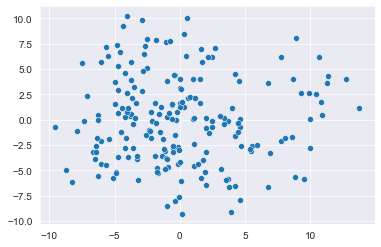

In [335]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pcs = pca.fit_transform(data)

pc1_values = pcs[:,0]
pc2_values = pcs[:,1]
sns.scatterplot(x=pc1_values, y=pc2_values)

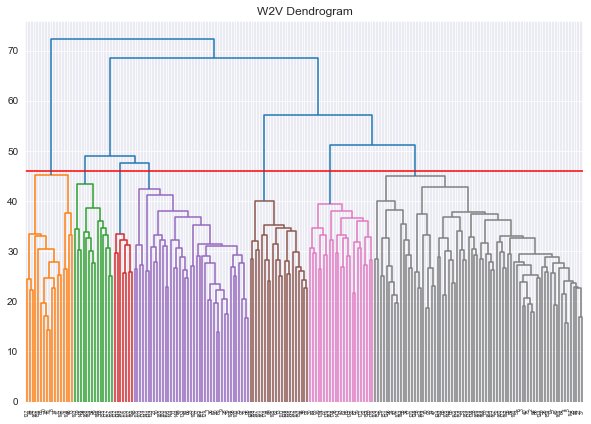

In [343]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("W2V Dendrogram")

clusters = shc.linkage(data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters, color_threshold=46)
plt.axhline(y = 46, color = 'r', linestyle = '-')
plt.show()

In [509]:
n_cluster=7

In [472]:
from sklearn.cluster import AgglomerativeClustering
import random

random.seed(42)

clustering_model = AgglomerativeClustering(n_clusters=n_cluster, affinity='euclidean', linkage='ward')
clustering_model.fit(data)
clustering_model.labels_

array([0, 1, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 2, 3, 0, 1, 3, 2, 3, 4, 1, 1,
       4, 1, 2, 2, 2, 2, 1, 4, 4, 2, 1, 2, 2, 3, 1, 2, 2, 1, 2, 1, 2, 4,
       2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 5, 2, 2, 1, 2, 2, 4, 4, 3, 5, 2, 4,
       1, 4, 2, 1, 1, 1, 0, 0, 0, 2, 4, 1, 0, 0, 2, 4, 4, 4, 2, 2, 2, 4,
       0, 5, 3, 3, 0, 2, 5, 1, 2, 1, 1, 5, 1, 2, 6, 1, 3, 2, 1, 0, 0, 2,
       3, 2, 2, 1, 6, 2, 1, 1, 1, 6, 2, 2, 6, 2, 2, 2, 3, 0, 3, 1, 2, 6,
       1, 1, 1, 2, 2, 4, 3, 4, 2, 1, 3, 4, 1, 5, 3, 3, 6, 1, 3, 2, 2, 4,
       2, 5, 0, 5, 2, 2, 2, 3, 0, 4, 2, 2, 2, 2, 5, 2, 1, 4, 2, 2, 4, 4,
       4, 5, 3, 2, 1, 6, 1, 2, 2, 1, 5, 2, 3, 5, 2, 3, 1, 5, 2, 3, 5],
      dtype=int64)

Text(0.5, 1.0, 'Labeled Clustered Data')

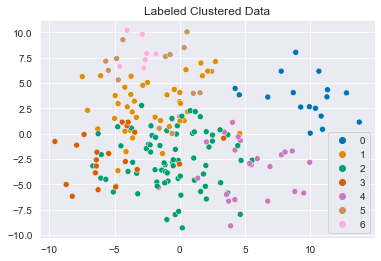

In [473]:
data_labels = clustering_model.labels_
sns.scatterplot(x=pc1_values, y=pc2_values,hue=data_labels,palette='colorblind').set_title('Labeled Clustered Data')

In [474]:
data['label']=clustering_model.labels_

In [604]:
data[data['label']==0]['label']

educational    0
training       0
university     0
pupils         0
committee      0
russia         0
polish         0
instruction    0
schools        0
school         0
teachers       0
teacher        0
students       0
japan          0
pupil          0
curriculum     0
workers        0
Name: label, dtype: int64

In [476]:
data[data['label']==1][:10]['label']

psychology    1
analysis      1
phenomena     1
doctrine      1
essence       1
separation    1
logic         1
ideas         1
standpoint    1
logical       1
Name: label, dtype: int64

In [477]:
data[data['label']==2]['label'][:10]

function        2
external        2
specific        2
concrete        2
perception      2
significance    2
factor          2
outcome         2
sensations      2
environment     2
Name: label, dtype: int64

In [478]:
data[data['label']==3]['label']

data               3
prior              3
judgments          3
operations         3
reasoning          3
propositions       3
meanings           3
existential        3
inference          3
hypothesis         3
criterion          3
validity           3
antecedent         3
valid              3
observations       3
existences         3
instrumental       3
valuation          3
hypotheses         3
experimentation    3
analytic           3
Name: label, dtype: int64

In [479]:
data[data['label']==4]['label']

response         4
formation        4
attitudes        4
impulses         4
insight          4
desirable        4
imagination      4
relatively       4
forming          4
routine          4
adult            4
comprehensive    4
capacities       4
occupations      4
technique        4
organs           4
acquired         4
extensive        4
overt            4
educative        4
stimuli          4
voluntary        4
socially         4
Name: label, dtype: int64

In [480]:
data[data['label']==5]['label']

referred        5
russell         5
pp              5
dewey           5
vol             5
ch              5
empiricism      5
pragmatism      5
writings        5
peirce          5
santayana       5
presentation    5
journal         5
pragmatic       5
Name: label, dtype: int64

In [481]:
data[data['label']==6]['label']

kant         6
aristotle    6
plato        6
leibniz      6
locke        6
spencer      6
hegel        6
Name: label, dtype: int64

In [482]:
for embedding in embedding_per_period:
    x=[list(embedding[str(w)]) for w in interesting_words if w in embedding]
    d=pd.DataFrame(x,index=words)
    clustering_model.fit(d)
    data_labels = clustering_model.labels_
    data['label '+str(embedding_per_period.index(embedding)+1)]=clustering_model.labels_

In [483]:
data

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,label,label 1,label 2,label 3
educational,1.377467,0.420994,-0.307362,0.711628,-0.118714,-1.248337,0.004006,0.339972,0.325315,0.338947,...,0.026654,-0.732489,0.506468,0.934076,-0.399785,-0.259811,0,4,1,2
psychology,1.089121,1.054996,-1.461231,0.361282,-0.925448,0.592833,-0.899291,-0.482961,-0.641737,-0.292767,...,-0.671748,-2.287897,-0.336860,0.191997,1.118951,0.326788,1,2,5,1
function,0.553835,0.399840,-1.261410,-0.166495,-1.018143,-0.242299,-1.043453,-0.652891,1.432574,0.348300,...,-0.196236,0.580076,-0.663131,-0.162855,0.354569,-0.272422,2,2,2,3
external,-0.169759,-0.159742,-0.619374,0.005735,-0.165766,0.016755,1.148048,0.267811,-0.680087,-1.002267,...,-1.401633,0.895954,0.421959,-1.211162,0.568684,-1.011344,2,2,2,3
specific,-0.420573,-0.729865,-0.791439,0.292931,-0.262971,0.253008,0.347490,0.391015,-0.544273,0.610203,...,0.980711,-0.725942,-0.548321,-0.062140,0.993029,-0.410091,2,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dualism,-2.231590,3.552882,-0.149404,0.711700,-1.723090,0.412202,-0.544984,-1.179437,-0.497726,-0.933789,...,-1.626007,1.078681,-2.231786,0.301455,-0.482871,-0.674097,1,1,5,1
journal,-0.023629,0.780928,2.589189,-2.631946,-3.961161,1.713387,-0.880712,-0.521357,1.581098,-0.675997,...,1.382336,0.361225,1.465138,-0.880137,1.395958,-1.031520,5,5,4,4
characteristics,-0.032285,0.914316,1.417082,-1.531526,-0.993550,-2.064116,0.703793,-0.073337,-0.320713,-1.646299,...,-1.452127,-0.281755,3.485008,-3.200230,1.951813,0.115434,2,6,2,3
analytic,2.373199,2.487093,-0.099743,-0.199698,-1.765188,-0.028977,0.887934,1.634340,-0.866528,-1.059664,...,-2.287087,-1.169145,-0.979357,2.075789,2.952860,-2.105064,3,3,3,0


In [484]:
data[data['label']==data['label 1']]

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,label,label 1,label 2,label 3
function,0.553835,0.399840,-1.261410,-0.166495,-1.018143,-0.242299,-1.043453,-0.652891,1.432574,0.348300,...,-0.196236,0.580076,-0.663131,-0.162855,0.354569,-0.272422,2,2,2,3
external,-0.169759,-0.159742,-0.619374,0.005735,-0.165766,0.016755,1.148048,0.267811,-0.680087,-1.002267,...,-1.401633,0.895954,0.421959,-1.211162,0.568684,-1.011344,2,2,2,3
specific,-0.420573,-0.729865,-0.791439,0.292931,-0.262971,0.253008,0.347490,0.391015,-0.544273,0.610203,...,0.980711,-0.725942,-0.548321,-0.062140,0.993029,-0.410091,2,2,2,3
concrete,0.236606,0.085234,-1.443989,-0.533595,-0.816071,1.133629,0.897653,-0.011508,0.421315,1.181080,...,-0.510127,-0.635014,0.074443,-1.061798,1.275794,-0.976591,2,2,2,3
perception,0.029964,2.204028,0.280453,-0.411681,1.251980,0.604888,0.935278,-0.375980,0.675425,-1.731307,...,0.642933,-0.508169,-0.331197,-0.421833,-0.681544,0.508441,2,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
operates,-4.102506,-0.202948,2.186289,-1.389863,-1.856069,-1.549397,0.687171,2.352408,0.559463,-0.524809,...,-2.254442,-0.563323,-0.615323,0.277610,0.308947,0.824203,2,2,2,3
experimentation,1.987719,0.725202,-0.697087,-0.539647,-0.174837,-1.539796,-0.367754,0.993815,-0.171830,-1.428638,...,-0.107196,0.169464,-1.049948,0.061571,-2.034641,1.163519,3,3,3,0
dualism,-2.231590,3.552882,-0.149404,0.711700,-1.723090,0.412202,-0.544984,-1.179437,-0.497726,-0.933789,...,-1.626007,1.078681,-2.231786,0.301455,-0.482871,-0.674097,1,1,5,1
journal,-0.023629,0.780928,2.589189,-2.631946,-3.961161,1.713387,-0.880712,-0.521357,1.581098,-0.675997,...,1.382336,0.361225,1.465138,-0.880137,1.395958,-1.031520,5,5,4,4


In [485]:
data[data['label 2']==data['label 1']]

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,label,label 1,label 2,label 3
function,0.553835,0.399840,-1.261410,-0.166495,-1.018143,-0.242299,-1.043453,-0.652891,1.432574,0.348300,...,-0.196236,0.580076,-0.663131,-0.162855,0.354569,-0.272422,2,2,2,3
external,-0.169759,-0.159742,-0.619374,0.005735,-0.165766,0.016755,1.148048,0.267811,-0.680087,-1.002267,...,-1.401633,0.895954,0.421959,-1.211162,0.568684,-1.011344,2,2,2,3
specific,-0.420573,-0.729865,-0.791439,0.292931,-0.262971,0.253008,0.347490,0.391015,-0.544273,0.610203,...,0.980711,-0.725942,-0.548321,-0.062140,0.993029,-0.410091,2,2,2,3
concrete,0.236606,0.085234,-1.443989,-0.533595,-0.816071,1.133629,0.897653,-0.011508,0.421315,1.181080,...,-0.510127,-0.635014,0.074443,-1.061798,1.275794,-0.976591,2,2,2,3
perception,0.029964,2.204028,0.280453,-0.411681,1.251980,0.604888,0.935278,-0.375980,0.675425,-1.731307,...,0.642933,-0.508169,-0.331197,-0.421833,-0.681544,0.508441,2,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
priori,0.808828,1.420310,-1.305309,1.597924,-0.208923,3.147649,1.296393,-0.608376,0.404516,-0.686047,...,-2.161876,-1.140010,-1.956919,0.120245,1.919747,-0.509766,1,3,3,0
hypotheses,2.347245,0.704971,-0.986020,-0.082666,0.241316,1.910890,0.109809,-3.386160,-1.132948,-1.389179,...,-0.174298,-0.837434,-0.079606,0.562721,-1.270621,0.360948,3,3,3,0
operates,-4.102506,-0.202948,2.186289,-1.389863,-1.856069,-1.549397,0.687171,2.352408,0.559463,-0.524809,...,-2.254442,-0.563323,-0.615323,0.277610,0.308947,0.824203,2,2,2,3
experimentation,1.987719,0.725202,-0.697087,-0.539647,-0.174837,-1.539796,-0.367754,0.993815,-0.171830,-1.428638,...,-0.107196,0.169464,-1.049948,0.061571,-2.034641,1.163519,3,3,3,0


In [486]:
from sklearn.metrics.cluster import adjusted_rand_score #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix

In [487]:
adjusted_rand_score(data['label'],data['label 1'])

0.31093262414127143

In [488]:
adjusted_mutual_info_score(data['label'],data['label 1'])

0.47967626866353724

In [489]:
contingency_matrix(data['label'], data['label 1'])

array([[ 1,  0,  0,  0, 16,  0,  0],
       [ 0,  1, 32,  8,  0,  0,  0],
       [10,  0, 53,  2,  0,  0,  9],
       [ 0,  0,  3, 15,  0,  0,  3],
       [14,  0,  9,  0,  0,  0,  0],
       [ 0,  9,  1,  0,  0,  3,  1],
       [ 0,  7,  0,  0,  0,  0,  0]], dtype=int64)

In [490]:
data.loc[(data['label']==data['label']['kant'])|(data['label 1']==data['label 1']['kant'])|(data['label 2']==data['label 2']['kant'])|(data['label 3']==data['label 3']['kant'])]

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,label,label 1,label 2,label 3
russell,0.146418,0.672131,0.454487,-0.871547,-3.525591,1.041317,-1.010117,1.425716,-3.771029,1.894954,...,-1.900686,4.087390,0.330042,-1.445709,1.210256,-1.088955,5,1,5,1
pp,-0.228367,0.958955,1.228886,0.699729,-1.751088,-0.723796,0.303497,-0.801223,0.790657,0.394964,...,-1.697022,0.370699,-0.979554,-1.594339,-0.453967,0.092105,5,1,5,1
dewey,-1.761184,-0.737775,3.842620,-1.127079,-0.071118,-0.449623,0.258867,0.871094,-1.921330,0.806989,...,1.744186,1.107749,-0.414425,1.411438,-0.270102,-1.349904,5,1,5,1
kant,0.808745,0.779224,-0.264817,-0.878399,-1.367192,3.049538,1.280766,2.243925,-1.783038,-2.492970,...,0.451445,0.876901,-0.553178,0.215174,1.637326,-0.349097,6,1,0,5
aristotle,1.217879,-0.933860,-1.540081,0.249236,-0.368231,0.736089,-0.301756,2.361981,-0.440074,-1.742830,...,-2.809229,1.210997,-1.210791,-0.489014,1.649468,2.623113,6,1,0,5
plato,1.721879,-1.317988,1.331310,-1.467859,0.650670,1.395759,-0.841688,2.924214,-0.884389,-0.957085,...,-0.307163,-0.938033,2.473322,0.139486,-1.053253,1.505198,6,1,0,5
leibniz,0.295424,-1.563069,-0.232631,0.559150,-0.567754,-1.721848,1.908064,1.463370,0.014190,0.113625,...,-0.021211,0.118693,0.281394,-2.178612,2.429670,2.177660,6,1,0,5
locke,2.451745,-0.436234,-2.042353,-0.441563,0.645216,0.848585,2.781551,4.427255,-1.719136,-2.620178,...,2.450519,0.680360,-1.010170,1.100597,2.763210,3.301461,6,1,0,5
spencer,0.007537,-0.058975,-0.136967,1.295518,-2.490044,0.394954,-2.008670,1.673615,-3.201132,1.071448,...,0.324135,0.115863,-0.414380,0.450630,1.592203,0.401105,6,1,0,5
empiricism,-0.766141,1.734501,-0.739779,-0.253992,0.355376,0.748172,-0.436592,1.010421,0.511154,0.525050,...,0.782816,-3.351015,0.257672,-3.721680,-1.206470,0.579590,5,1,0,1


In [1]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = [str(i+1)+str(j+1) for i in range(len(embedding_per_period)) for j in range(n_cluster)],
      color = "blue"
    ),
    link = dict(
      source = Source, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = Target,
      value = Value
  ))])

fig.update_layout(title_text="Cluster Sankey Diagram", font_size=10)
fig.show()

NameError: name 'embedding_per_period' is not defined

In [556]:
Source=list()
for i in range(14):
    for j in range(7):
        Source.append(i)
Target=[i for i in range(7,14)]*7+[i for i in range(14,21)]*7

In [585]:
Value=[0 for i in range(0,98)]
for index, row in data.iterrows():
    Value[int(row['label 1'])*7+int(row['label 2'])]+=1
    Value[int(row['label 2'])*7+int(row['label 3'])+49]+=1

In [602]:
data[data['label 3']==4]

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,label,label 1,label 2,label 3
vol,-1.774904,-0.058553,-0.881003,-0.521913,-2.024422,-0.047724,-0.278654,1.231974,4.831011,1.419119,...,-3.903095,-0.095503,-0.838145,-2.139224,1.268440,0.355902,5,5,4,4
ch,0.734930,0.405290,-1.186593,-1.944811,-0.322588,-0.914722,0.290822,-0.926292,1.784419,-2.905833,...,-1.010730,-1.586918,-0.074906,1.098107,1.149978,2.077579,5,5,4,4
journal,-0.023629,0.780928,2.589189,-2.631946,-3.961161,1.713387,-0.880712,-0.521357,1.581098,-0.675997,...,1.382336,0.361225,1.465138,-0.880137,1.395958,-1.031520,5,5,4,4
